In [8]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path

In [11]:
p = Path("eval_data")
text_df = pd.read_json(p / "text_performance.jsonl", orient="records", lines=True)
audio_df = pd.read_json(p / "audio_performance.jsonl", orient="records", lines=True)
ensemble_df = pd.read_json(p / "ensemble_performance_max.jsonl", orient="records", lines=True)
dummy_df = pd.read_json(p / "dummy_baseline.jsonl", orient="records", lines=True)

df = pd.concat([text_df, audio_df, ensemble_df])
df = df.reset_index()

In [12]:
# only keep id-level
df = df[df["level"] == "id"]

# only assess based on scores on test set and macro f1
df_test = df[(df["score_type"] == "f1_macro") & (df["split"] == "test")]

# split into baseline and transformers for plotting
baselines = df_test[df_test["is_baseline"] == 1]
transformers = df_test[df_test["is_baseline"] == 0]

In [13]:
# find best multiclass model on test set for both baseline and transformer
def get_best_model(df):
    best_idx = df["value"].astype(float).idxmax()
    return best_idx, df.at[best_idx, "model_name"]

In [14]:
# best text models
baseline_text_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 1) & (df_test["type"] == "text")]
transformer_text_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 0) & (df_test["type"] == "text")]

best_baseline_text_idx, best_baseline_text_name = get_best_model(baseline_text_df)
best_transformer_text_idx, best_transformer_text_name = get_best_model(transformer_text_df)

In [15]:
# best audio models
baseline_audio_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 1) & (df_test["type"] == "audio")]
transformer_audio_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 0) & (df_test["type"] == "audio")]

best_baseline_audio_idx, best_baseline_audio_name = get_best_model(baseline_audio_df)
best_transformer_audio_idx, best_transformer_audio_name = get_best_model(transformer_audio_df)

In [71]:
# plotting functions
def get_conf_matrix(df, model_name, target_class="multiclass", split="test"):
    df = df[(df["score_type"] == "confusion_matrix") & (df["model_name"] == model_name) & (df["target_class"] == target_class) & (df["split"] == split)]
    conf_mat = df["value"]
    
    if len(conf_mat) > 1:
        raise ValueError("More than 1 confusion matrix returned. Subset better..")
    if target_class == "multiclass":
        idx_mapping = sorted(["TD", "DEPR", "ASD", "SCHZ"])
    else:
        idx_mapping = sorted(["TD", target_class])

    conf_mat = np.stack(df["value"]).squeeze()
    conf_df = pd.DataFrame(conf_mat, index=idx_mapping, columns=idx_mapping)

    return conf_df

def plot_conf_matrix(conf_matrix, title, model_name, annot=True):        
    ax = plt.axes()
    sns.heatmap(conf_matrix, annot=annot, annot_kws={"size": 16})
    ax.set_title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"conf_mat_{model_name}.png", bbox_inches="tight", dpi=300)
    plt.show()    


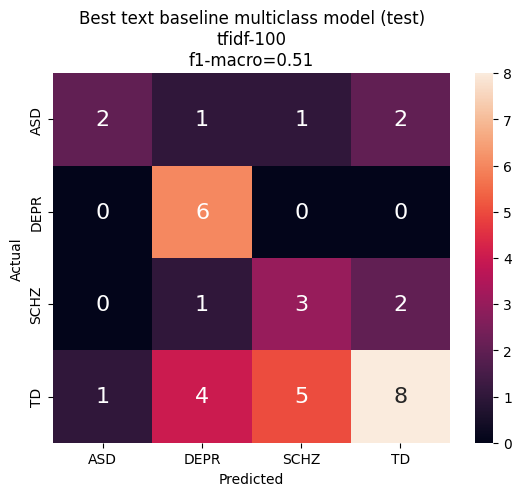

In [58]:
best_multiclass_baseline_text_conf = get_conf_matrix(df, best_baseline_text_name)
title = f"Best text baseline multiclass model (test)\n{best_baseline_text_name}\nf1-macro={round(df.at[best_baseline_text_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_baseline_text_conf, title, best_baseline_text_name)


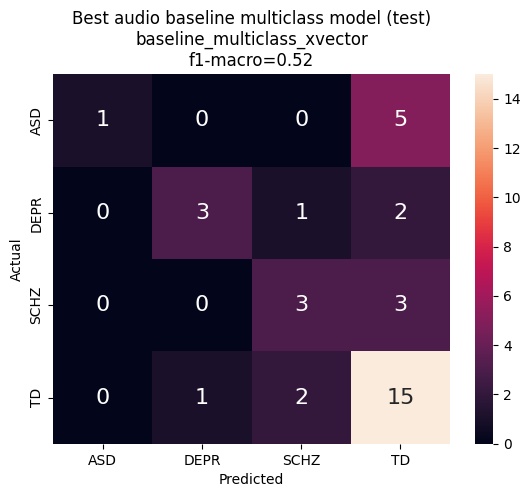

In [59]:
best_multiclass_baseline_audio_conf = get_conf_matrix(df, best_baseline_audio_name)
title = f"Best audio baseline multiclass model (test)\n{best_baseline_audio_name}\nf1-macro={round(df.at[best_baseline_audio_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_baseline_audio_conf, title, best_baseline_audio_name)


In [75]:
# load trial level performance
trial_audio = pd.read_json(p / f"trial_level_{best_baseline_audio_name}.jsonl", orient="records", lines=True).\
    assign(model_name=best_baseline_audio_name, target_class="multiclass", split="test")
trial_text = pd.read_json(p / f"trial_level_baseline_multiclass_{best_baseline_text_name}.jsonl", orient="records", lines=True).\
    assign(model_name=best_baseline_text_name, target_class="multiclass", split="test")

# get confusion matrix with trial information
audio_trial_conf = get_conf_matrix(trial_audio, best_baseline_audio_name, target_class="multiclass", split="test")
text_trial_conf = get_conf_matrix(trial_text, best_baseline_text_name, target_class="multiclass", split="test")

# calculate number of trials per class
audio_trial_conf = audio_trial_conf.assign(total=audio_trial_conf.sum(axis=1))
text_trial_conf = text_trial_conf.assign(total=text_trial_conf.sum(axis=1))

# make all values strings
audio_trial_conf = audio_trial_conf.astype(str)
text_trial_conf = text_trial_conf.astype(str)

# for each group, add the total number of trials to the true positives
for idx, row in audio_trial_conf.iterrows():
    audio_trial_conf.at[idx, idx] = f"{row[idx]} ({row['total']})"
for idx, row in text_trial_conf.iterrows():
    text_trial_conf.at[idx, idx] = f"{row[idx]} ({row['total']})"

audio_trial_conf = audio_trial_conf.drop(columns=["total"])
text_trial_conf = text_trial_conf.drop(columns=["total"])



In [103]:
from typing import Optional


def plot_heatmap_with_multiple_annotations(
    conf_matrix: pd.DataFrame, 
    annotation: pd.DataFrame, 
    title: str, 
    model_name: str, 
    vmin: Optional[int] = None, 
    vmax: Optional[int] = None):
    
    ax = plt.axes()
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16, "va" : "bottom"}, vmin=vmin, vmax=vmax)
    sns.heatmap(conf_matrix, annot=annotation, annot_kws={"size": 10, "va" : "top"}, fmt="", cbar=False, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"conf_mat_multiple_annotation_{model_name}.png", bbox_inches="tight", dpi=300)
    plt.show()


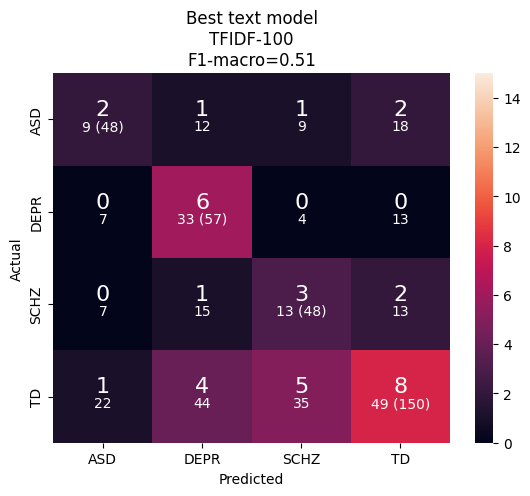

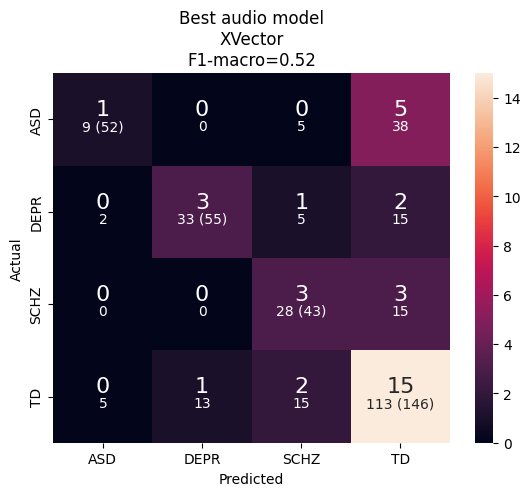

In [106]:
text_title = f"Best text model\nTFIDF-100\nF1-macro={round(df.at[best_baseline_text_idx, 'value'],2)}"
audio_title = f"Best audio model\nXVector\nF1-macro={round(df.at[best_baseline_audio_idx, 'value'],2)}"
plot_heatmap_with_multiple_annotations(best_multiclass_baseline_text_conf, text_trial_conf, text_title, best_baseline_text_name, vmin=0, vmax=15)
plot_heatmap_with_multiple_annotations(best_multiclass_baseline_audio_conf, audio_trial_conf, audio_title, best_baseline_audio_name, vmin=0, vmax=15)